In [1]:
%run config.ipynb

import tensorflow as tf
print("Num GPUs Available: ", tf.config.experimental.list_physical_devices('GPU'))
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Dense, Embedding, LSTM, Bidirectional, GlobalMaxPooling1D
from tensorflow.keras.models import Model, clone_model

Num GPUs Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Read Datasets

In [2]:
# business = pd.read_json("data/yelp_academic_dataset_business.json", lines=True)
# check_in = pd.read_json("data/yelp_academic_dataset_checkin.json", lines=True)
# review = pd.read_csv("data/yelp_academic_dataset_sample_review.csv")
# review = pd.read_csv("data/yelp_academic_dataset_sample005_review.csv")
# tip = pd.read_json("data/yelp_academic_dataset_tip.json", lines=True)
# user = pd.read_json("data/yelp_academic_dataset_user.json", lines=True)

df = pd.read_csv("data/yelp_academic_dataset_sample005_filter.csv")
df.head(1)

,review_id,user_id,business_id,review_stars,review_text,review_text_after_cleaning,user_review_count,user_elite,user_friends,user_fans,user_average_stars,user_total_compliments,business_name,business_categories,business_stars,to_recommend,num_user_friends
0,yNB39szX3M8mTEzTtsgoCw,Y1iCYGvLf4ifPoXlKLGq-w,o2Qh4SiGYJ7BK4hP7dfkrw,5,This is an amazing indian Bistro!!I If I do sa...,amaz bistroi say myself never cuisin glad expe...,1,0,None,0,5.0,0,Saffron Indian Bistro,"Restaurants, Indian",4.5,True,0


In [3]:
X = df["review_text_after_cleaning"]

## Split Dataset

In [4]:
y = df["to_recommend"]
# y = y.apply(lambda x : x - 1) # convert range(1,7) to range(0,6) for more precise when adding dense layer
y = y.apply(lambda x : 1 if x else 0)
df_train, df_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

## Word Embedding

In [5]:
MAX_VOCAB_SIZE = 50000
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(df_train)
sequences_train = tokenizer.texts_to_sequences(df_train)
sequences_test = tokenizer.texts_to_sequences(df_test)

In [6]:
word2idx = tokenizer.word_index
V = len(word2idx)
print('Found %s unique tokens.' % V)

Found 120640 unique tokens.


In [7]:
X_train = pad_sequences(sequences_train, maxlen=150)
print('Shape of data train tensor:', X_train.shape)

T = X_train.shape[1]

X_test = pad_sequences(sequences_test, maxlen=T)
print('Shape of data test tensor:', X_test.shape)

Shape of data train tensor: (268540, 150)
Shape of data test tensor: (132267, 150)


## Modelling

In [11]:
def fit_model(model, epochs=3, batch_size=128, loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy']):
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    r = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test))
    plot(r)
    return model, r

def plot(r):
    plt.xlabel('# epochs')
    length = len(r.history[next(iter(r.history))])
    plt.xticks(np.arange(length), np.arange(1, length+1))
    plt.plot(r.history['loss'], label='loss')
    plt.plot(r.history['val_loss'], label='val_loss')
    plt.plot(r.history['accuracy'], label='acc')
    plt.plot(r.history['val_accuracy'], 'm', label='val_acc')
    plt.legend()

def create_model():
    D = 100
    num_words = min(MAX_VOCAB_SIZE, V + 1)
    i = Input(shape=(T,))
    x = Embedding(num_words, D)(i)
    x = LSTM(D, return_sequences=True)(x)
    x = GlobalMaxPooling1D()(x)
    x = Dense(2, activation='softmax')(x)
    model = Model(i, x)
    model.summary(105)
    return model

Model: "functional_5"
_________________________________________________________________________________________________________
Layer (type)                                   Output Shape                              Param #         
input_3 (InputLayer)                           [(None, 543)]                             0               
_________________________________________________________________________________________________________
embedding_2 (Embedding)                        (None, 543, 100)                          5000000         
_________________________________________________________________________________________________________
bidirectional_2 (Bidirectional)                (None, 543, 100)                          60400           
_________________________________________________________________________________________________________
global_max_pooling1d_2 (GlobalMaxPooling1D)    (None, 100)                               0               
________________________

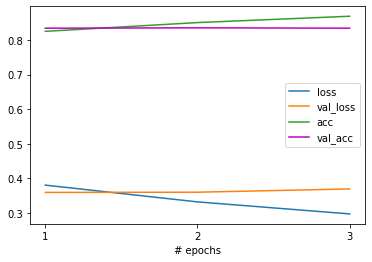

In [18]:
m, r = fit_model(create_model())

Model: "functional_7"
_________________________________________________________________________________________________________
Layer (type)                                   Output Shape                              Param #         
input_4 (InputLayer)                           [(None, 543)]                             0               
_________________________________________________________________________________________________________
embedding_3 (Embedding)                        (None, 543, 100)                          5000000         
_________________________________________________________________________________________________________
lstm_3 (LSTM)                                  (None, 543, 100)                          80400           
_________________________________________________________________________________________________________
global_max_pooling1d_3 (GlobalMaxPooling1D)    (None, 100)                               0               
________________________

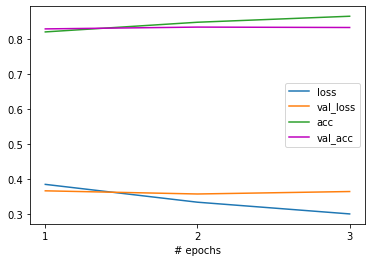

In [20]:
m1, r1 = fit_model(create_model())

Model: "functional_13"
________________________________________________________________________________________________________________________
Layer (type)                                          Output Shape                                    Param #           
input_8 (InputLayer)                                  [(None, 495)]                                   0                 
________________________________________________________________________________________________________________________
embedding_7 (Embedding)                               (None, 495, 100)                                3000000           
________________________________________________________________________________________________________________________
bidirectional_6 (Bidirectional)                       (None, 495, 100)                                60400             
________________________________________________________________________________________________________________________
global_ma

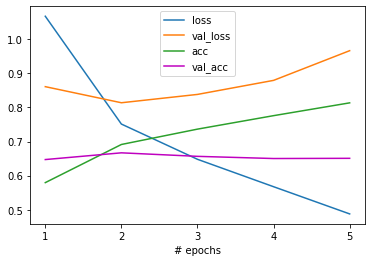

In [39]:
m2, r2 = fit_model(create_model())